# Predicting gender from names

## Table of Contents

##### I. <a href=#I>Preliminary steps</a>
##### II. <a href=#II>Prepare the data</a>
##### III. <a href=#III>Feed-forward neural network model</a>
##### IV. <a href=#IV>Long short-term memory model</a>
##### V. <a href=#V>Naive discriminative learning model</a>

## I. Preliminary steps <a ID="I"></a> 

### Import necessary libraries and set up the working directory

In [1]:
### Import necessary packages
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dropout, Dense
from keras.optimizers import Adam, Nadam, RMSprop, SGD
from keras.activations import relu, elu
from keras.losses import binary_crossentropy
from keras import metrics
from keras.models import load_model
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import talos as ta

### Set working directory
TOP = '/media/sf_PostDoc_ooominds/Programming/Deep_text_modelling_package_repo/'
WD = '/media/sf_PostDoc_ooominds/Programming/Deep_text_modelling_package_repo/package/'
os.chdir(WD)

### Import local packages
import deep_text_modelling.preprocessing as pr
import deep_text_modelling.modelling as md
import deep_text_modelling.evaluation as ev

# Display option for dataframes
pd.set_option('display.max_colwidth', 100) # Max width of columns when dispalying datasets
PREVIOUS_MAX_ROWS = pd.options.display.max_rows
pd.options.display.max_rows = 20

Using TensorFlow backend.


In [14]:
import imp
imp.reload(pr)
imp.reload(md)
imp.reload(ev)

<module 'deep_text_modelling.evaluation' from '/media/sf_PostDoc_ooominds/Programming/Deep_text_modelling_package_repo/package/deep_text_modelling/evaluation.py'>

### Define file paths

In [2]:
NAMES_FULL_CSV = TOP + "illustrative_examples/names/Data/Names_full.csv"
NAMES_TRAIN_CSV = TOP + "illustrative_examples/names/Data/Names_train.csv"
NAMES_VALID_CSV = TOP + "illustrative_examples/names/Data/Names_valid.csv"
NAMES_TEST_CSV = TOP + "illustrative_examples/names/Data/Names_test.csv"
NAMES_TRAIN_GZ = TOP + "illustrative_examples/names/Data/Names_train.gz"
NAMES_VALID_GZ = TOP + "illustrative_examples/names/Data/Names_valid.gz"
NAMES_TEST_GZ = TOP + "illustrative_examples/names/Data/Names_test.gz"
CUE_INDEX = TOP + "illustrative_examples/names/Data/Cue_index.csv"
OUTCOME_INDEX = TOP + "illustrative_examples/names/Data/Outcome_index.csv"
TEMP_DIR = TOP + "illustrative_examples/names/Data/"

### Parameters to use

In [3]:
N_outcomes = 2  # number of most frequent outcomes to keep 
N_cues = 26  # number of cues to keep (all alphabet letters)
max_len = 11 # consider only the first 'max_len' cues in a sequence when applying LSTM (11 is the longest name in the dataset)
no_threads = 4 # Number of CPU cores to use
prop_valid = 1/10 # proportion of validation data
prop_test = 1/10 # proportion of test data

## II. Prepare the data <a name="II"></a> 

### Load the data

In [6]:
names_full = pd.read_csv(NAMES_FULL_CSV)
print(f'Number of examples: {len(names_full)}')
names_full.head(5)

Number of examples: 6782


,first_name,gender
0,John,m
1,William,m
2,James,m
3,Charles,m
4,George,m


### Prepare the cues and outcomes

In [7]:
# Create the unigraph cues
names_full['cues'] = names_full['first_name'].apply(lambda s: pr.orthoCoding(s, gram_size = 1))

# Rename the column gender as 'outcomes'
names_full.rename(columns={"gender": "outcomes"}, inplace = True)
names_full = names_full[['cues', 'outcomes']]
names_full.head(5)

,cues,outcomes
0,j_o_h_n,m
1,w_i_l_l_i_a_m,m
2,j_a_m_e_s,m
3,c_h_a_r_l_e_s,m
4,g_e_o_r_g_e,m


### Create index systems for the cues and outcomes

In [10]:
# Create the files containing the index systems
pr.create_index_systems_from_df(data = names_full, 
                                cue_index_path = CUE_INDEX, 
                                outcome_index_path = OUTCOME_INDEX)

In [5]:
# Import the cue index system
cue_to_index = pr.import_index_system(CUE_INDEX, N_tokens = N_cues)
pr.display_dictionary(cue_to_index, start = 0, end = 5)

{a: 1}
{e: 2}
{n: 3}
{i: 4}
{l: 5}


In [11]:
# Order dictionary alphabetically
cue_to_index = {k:(i+1) for i,k in enumerate(sorted(cue_to_index.keys()))}
pr.display_dictionary(cue_to_index, start = 0, end = 5)

{a: 1}
{b: 2}
{c: 3}
{d: 4}
{e: 5}


In [6]:
# Import the outcome index system
outcome_to_index = pr.import_index_system(OUTCOME_INDEX)
outcome_to_index

{'m': 1, 'f': 2}

In [7]:
# Reverse the cue dictionary
index_to_cue = pr.reverse_dictionary(cue_to_index)
# Reverse the outcome dictionary
index_to_outcome = pr.reverse_dictionary(outcome_to_index)
index_to_outcome

{1: 'm', 2: 'f'}

### Split into training, validation and test sets

In [15]:
# Create train, valid and test set files
pr.df_train_valid_test_split(data = names_full, 
                             train_data_path = NAMES_TRAIN_CSV, 
                             valid_data_path = NAMES_VALID_CSV, 
                             test_data_path = NAMES_TEST_CSV, 
                             p_valid = prop_valid, 
                             p_test = prop_test)

- Number of rows in the original set is 6782
- Number of rows in the training set is 5426
- Number of rows in the validation set is 678
- Number of rows in the test set is 678


In [5]:
# Load the train, valid and test sets
names_train = pd.read_csv(NAMES_TRAIN_CSV, sep=',', index_col=0, na_filter = False)
names_valid = pd.read_csv(NAMES_VALID_CSV, sep=',', index_col=0, na_filter = False)
names_test = pd.read_csv(NAMES_VALID_CSV, sep=',', index_col=0, na_filter = False)

## III. Feed-forward neural network model <a ID="III"></a> 

### Tokenisation

In [11]:
# Extract an event
event1 = names_train.iloc[[1]]
event1

,cues,outcomes
6170,k_y_r_i_e,f


In [12]:
# cues
cues1 = names_train.loc[names_train.index[1], 'cues']
cues1_onehot_FNN = md.seq_to_onehot_1darray(cues1, index_system = cue_to_index, N_tokens = N_cues)
cues1_onehot_FNN

array([0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 1., 0.])

In [13]:
# outcomes
outcomes2 = names_train.loc[names_train.index[1], 'outcomes']
outcomes2_onehot_FNN = md.seq_to_onehot_1darray(outcomes2, index_system = outcome_to_index, N_tokens = N_outcomes)
outcomes2_onehot_FNN

array([0., 1.])

### Build a simple FNN model

Build a simple FNN with two hidden layers having 64 units 

In [21]:
### Hyperparameters to use
p = {'epochs': 10, # number of iterations on the full set 
    'batch_size': 16, 
    'hidden_layers': 2, # number of hidden layers 
    'hidden_neuron':64, # number of neurons in the input layer 
    'lr': 0.0001, # learning rate       
    'dropout': 0.2, 
    'optimizer': Adam, 
    'losses': binary_crossentropy, 
    'activation': relu, 
    'last_activation': 'sigmoid'}

# Model fitting
FNN_out, FNN_model = md.train_FNN(data_train = names_train, 
                                  data_valid = names_valid, 
                                  num_cues = N_cues, 
                                  num_outcomes = N_outcomes, 
                                  cue_index = cue_to_index, 
                                  outcome_index = outcome_to_index, 
                                  generator = md.generator_df_FNN,
                                  shuffle = False, 
                                  use_multiprocessing = False, 
                                  num_threads = 0, 
                                  verbose = 2,
                                  metrics = ['accuracy'],
                                  params = p)

Epoch 1/10
 - 2s - loss: 0.6911 - acc: 0.5304 - val_loss: 0.6776 - val_acc: 0.5952
Epoch 2/10
 - 1s - loss: 0.6738 - acc: 0.5807 - val_loss: 0.6604 - val_acc: 0.6362
Epoch 3/10
 - 1s - loss: 0.6626 - acc: 0.6123 - val_loss: 0.6451 - val_acc: 0.6548
Epoch 4/10
 - 1s - loss: 0.6502 - acc: 0.6243 - val_loss: 0.6320 - val_acc: 0.6592
Epoch 5/10
 - 1s - loss: 0.6406 - acc: 0.6387 - val_loss: 0.6226 - val_acc: 0.6622
Epoch 6/10
 - 1s - loss: 0.6311 - acc: 0.6480 - val_loss: 0.6162 - val_acc: 0.6570
Epoch 7/10
 - 1s - loss: 0.6258 - acc: 0.6523 - val_loss: 0.6116 - val_acc: 0.6592
Epoch 8/10
 - 1s - loss: 0.6245 - acc: 0.6561 - val_loss: 0.6089 - val_acc: 0.6615
Epoch 9/10
 - 1s - loss: 0.6184 - acc: 0.6610 - val_loss: 0.6068 - val_acc: 0.6629
Epoch 10/10
 - 1s - loss: 0.6171 - acc: 0.6560 - val_loss: 0.6055 - val_acc: 0.6615


In [22]:
FNN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 64)                1728      
_________________________________________________________________
dropout_15 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_16 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 130       
Total params: 6,018
Trainable params: 6,018
Non-trainable params: 0
_________________________________________________________________


In [23]:
# Save the model and training history
MODEL_PATH = TOP + 'illustrative_examples/names/Results/FNN_names.h5'
HISTORY_PATH = TOP + 'illustrative_examples/names/Results/FNN_history_dict_names'
FNN_model.save(MODEL_PATH)  # creates a HDF5 file 
md.save_history(history = FNN_out, path = HISTORY_PATH)
del FNN_model, FNN_out  # deletes the existing model and history dictionary

# Load the model and training history
FNN_model = load_model(MODEL_PATH)
FNN_history_dict = md.load_history(path = HISTORY_PATH)

### Tune the parameters to find a good model

In [26]:
### Parameter tuning using grid search 
p = {'epochs': [1, 5, 10, 20, 30], # number of iterations on the full set (x5)
     'batch_size': [8, 16, 32, 64, 128, 256], # (x6)
     'hidden_layers':[0, 1, 2], # number of hidden layers (x3)
     'hidden_neuron':[16, 32, 64, 128], # number of neurons in the input layer (x4)
     'lr': [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01], # learning rate (x7)       
     'dropout': [0, 0.1, 0.2, 0.3, 0.4], # (x5)
     'optimizer': [Adam, RMSprop], # (x2)
     'losses': [binary_crossentropy], # (x1)
     'activation':[relu, elu], # (x2)
     'last_activation': ['sigmoid'] # (x1)
     }
# => Total number of combinations: 5*6*3*4*7*5*2*1*2*1 = 50400

### Grid search 
TUNING_PATH = TOP + 'illustrative_examples/names/Results/grid_search_FNN_names.csv'
md.grid_search_FNN(data_train = names_train, 
                   data_valid = names_valid, 
                   num_cues = N_cues, 
                   num_outcomes = N_outcomes, 
                   cue_index = cue_to_index, 
                   outcome_index = outcome_to_index,
                   generator = md.generator_df_FNN,
                   params = p,
                   prop_grid = 3e-4, 
                   tuning_output_file = TUNING_PATH, 
                   shuffle = False, 
                   use_multiprocessing = False, 
                   num_threads = 0, 
                   verbose = 0)

Iteration 1 out of 15: {'epochs': 5, 'batch_size': 16, 'hidden_layers': 2, 'hidden_neuron': 16, 'lr': 0.0002, 'dropout': 0.3, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function binary_crossentropy at 0x7fb6276b7d90>, 'activation': <function relu at 0x7fb62766dd90>, 'last_activation': 'sigmoid'}

Iteration 2 out of 15: {'epochs': 1, 'batch_size': 8, 'hidden_layers': 1, 'hidden_neuron': 64, 'lr': 0.002, 'dropout': 0.3, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function binary_crossentropy at 0x7fb6276b7d90>, 'activation': <function elu at 0x7fb62766db70>, 'last_activation': 'sigmoid'}

Iteration 3 out of 15: {'epochs': 1, 'batch_size': 32, 'hidden_layers': 0, 'hidden_neuron': 16, 'lr': 0.0005, 'dropout': 0.3, 'optimizer': <class 'keras.optimizers.RMSprop'>, 'losses': <function binary_crossentropy at 0x7fb6276b7d90>, 'activation': <function relu at 0x7fb62766dd90>, 'last_activation': 'sigmoid'}

Iteration 4 out of 15: {'epochs': 5, 'batch_size': 64, 'hidde

Iteration 7 produced the highest validation accuracy, corresponding to the following parameters:

### Assessing the grid search using talos

In [29]:
# Import the results file to analyse the results with talos
r = ta.Reporting(TUNING_PATH)

# get the number of rounds in the Scan
r.rounds()

15

In [42]:
# Display the dataframe containing the tuning results
r.data

,epochs,batch_size,hidden_layers,hidden_neuron,lr,dropout,optimizer,losses,activation,last_activation,loss,acc,precision,recall,f1score,val_loss,val_acc,val_precision,val_recall,val_f1score
0,5,16,2,16,0.0002,0.3,<class 'keras.optimizers.RMSprop'>,<function binary_crossentropy at 0x7fb6276b7d90>,<function relu at 0x7fb62766dd90>,sigmoid,0.669620,0.592183,0.596286,0.573193,0.582540,0.658398,0.630208,0.633595,0.620536,0.626227
1,1,8,1,64,0.0020,0.3,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7fb6276b7d90>,<function elu at 0x7fb62766db70>,sigmoid,0.636240,0.637168,0.638922,0.638459,0.635707,0.622934,0.656250,0.656982,0.654762,0.655591
2,1,32,0,16,0.0005,0.3,<class 'keras.optimizers.RMSprop'>,<function binary_crossentropy at 0x7fb6276b7d90>,<function relu at 0x7fb62766dd90>,sigmoid,0.717758,0.501849,0.501217,0.602256,0.545619,0.715298,0.523810,0.523707,0.569940,0.543929
3,5,64,2,32,0.0005,0.4,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7fb6276b7d90>,<function elu at 0x7fb62766db70>,sigmoid,0.648238,0.622954,0.624664,0.617746,0.620708,0.615619,0.666406,0.667041,0.664062,0.665465
4,5,32,2,128,0.0005,0.0,<class 'keras.optimizers.RMSprop'>,<function binary_crossentropy at 0x7fb6276b7d90>,<function elu at 0x7fb62766db70>,sigmoid,0.605770,0.673169,0.673459,0.672152,0.672752,0.609353,0.666667,0.667119,0.666667,0.666815
5,30,64,2,32,0.0100,0.3,<class 'keras.optimizers.RMSprop'>,<function binary_crossentropy at 0x7fb6276b7d90>,<function relu at 0x7fb62766dd90>,sigmoid,0.555755,0.718192,0.718192,0.718192,0.718192,0.587138,0.690625,0.690625,0.690625,0.690625
6,10,32,2,64,0.0010,0.0,<class 'keras.optimizers.Adam'>,<function binary_crossentropy at 0x7fb6276b7d90>,<function relu at 0x7fb62766dd90>,sigmoid,0.532312,0.730492,0.730421,0.730584,0.730390,0.590935,0.687500,0.685486,0.693452,0.689315
7,30,8,0,16,0.0010,0.4,<class 'keras.optimizers.RMSprop'>,<function binary_crossentropy at 0x7fb6276b7d90>,<function elu at 0x7fb62766db70>,sigmoid,0.603938,0.670077,0.670234,0.669801,0.669954,0.606275,0.665179,0.665037,0.665179,0.665050
8,1,256,2,16,0.0020,0.4,<class 'keras.optimizers.RMSprop'>,<function binary_crossentropy at 0x7fb6276b7d90>,<function relu at 0x7fb62766dd90>,sigmoid,0.704483,0.505022,0.504909,0.499070,0.501794,0.682007,0.574219,0.588312,0.494141,0.537058
9,5,256,2,128,0.0005,0.1,<class 'keras.optimizers.RMSprop'>,<function binary_crossentropy at 0x7fb6276b7d90>,<function elu at 0x7fb62766db70>,sigmoid,0.610604,0.666388,0.666978,0.664435,0.665683,0.605098,0.659180,0.661373,0.652344,0.656827


In [49]:
r.data.columns

Index(['epochs', 'batch_size', 'hidden_layers', 'hidden_neuron', 'lr',
       'dropout', 'optimizer', 'losses', 'activation', 'last_activation',
       'loss', 'acc', 'precision', 'recall', 'f1score', 'val_loss', 'val_acc',
       'val_precision', 'val_recall', 'val_f1score'],
      dtype='object')

In [37]:
# get the highest result for any metric
print(f"- Highest validation accuracy: {r.high('val_acc')}")
print(f"- Highest validation f1-score: {r.high('f1score')}")

- Highest validation accuracy: 0.690625
- Highest validation f1-score: 0.730390268140996


In [43]:
# get the round with the best result
r.rounds2high(metric = 'val_acc')

5

In [51]:
# get the best paramaters
r.data.iloc[5,]

epochs                                                           30
batch_size                                                       64
hidden_layers                                                     2
hidden_neuron                                                    32
lr                                                             0.01
dropout                                                         0.3
optimizer                        <class 'keras.optimizers.RMSprop'>
losses             <function binary_crossentropy at 0x7fb6276b7d90>
activation                        <function relu at 0x7fb62766dd90>
last_activation                                             sigmoid
loss                                                       0.555755
acc                                                        0.718192
precision                                                  0.718192
recall                                                     0.718192
f1score                                         

### Retraining with the best parameters

In [52]:
### Hyperparameters to use
p = {'epochs': 30, # number of iterations on the full set 
    'batch_size': 64, 
    'hidden_layers': 2, # number of hidden layers 
    'hidden_neuron':32, # number of neurons in the input layer 
    'lr': 0.01, # learning rate       
    'dropout': 0.3, 
    'optimizer': RMSprop, 
    'losses': binary_crossentropy, 
    'activation': relu, 
    'last_activation': 'sigmoid'}

# Model fitting
FNN_out, FNN_model = md.train_FNN(data_train = names_train, 
                                  data_valid = names_valid, 
                                  num_cues = N_cues, 
                                  num_outcomes = N_outcomes, 
                                  cue_index = cue_to_index, 
                                  outcome_index = outcome_to_index, 
                                  generator = md.generator_df_FNN,
                                  shuffle = False, 
                                  use_multiprocessing = False, 
                                  num_threads = 0, 
                                  verbose = 2,
                                  metrics = ['accuracy'],
                                  params = p)

Epoch 1/30
 - 1s - loss: 0.6505 - acc: 0.6217 - val_loss: 0.6140 - val_acc: 0.6609
Epoch 2/30
 - 0s - loss: 0.6178 - acc: 0.6614 - val_loss: 0.5950 - val_acc: 0.6742
Epoch 3/30
 - 0s - loss: 0.6089 - acc: 0.6695 - val_loss: 0.6023 - val_acc: 0.6711
Epoch 4/30
 - 0s - loss: 0.6072 - acc: 0.6779 - val_loss: 0.5934 - val_acc: 0.6781
Epoch 5/30
 - 0s - loss: 0.5919 - acc: 0.6818 - val_loss: 0.5934 - val_acc: 0.6766
Epoch 6/30
 - 1s - loss: 0.5953 - acc: 0.6843 - val_loss: 0.5928 - val_acc: 0.6867
Epoch 7/30
 - 0s - loss: 0.5890 - acc: 0.6866 - val_loss: 0.5960 - val_acc: 0.6891
Epoch 8/30
 - 0s - loss: 0.5874 - acc: 0.6902 - val_loss: 0.6018 - val_acc: 0.6867
Epoch 9/30
 - 0s - loss: 0.5823 - acc: 0.6950 - val_loss: 0.5982 - val_acc: 0.6852
Epoch 10/30
 - 0s - loss: 0.5800 - acc: 0.7015 - val_loss: 0.6024 - val_acc: 0.6883
Epoch 11/30
 - 0s - loss: 0.5797 - acc: 0.7038 - val_loss: 0.6060 - val_acc: 0.6914
Epoch 12/30
 - 0s - loss: 0.5819 - acc: 0.6955 - val_loss: 0.5918 - val_acc: 0.6914
E

In [59]:
# Save the model and training history
MODEL_PATH = TOP + 'illustrative_examples/names/Results/FNN_final_names.h5'
HISTORY_PATH = TOP + 'illustrative_examples/names/Results/FNN_final_history_dict_names'
FNN_model.save(MODEL_PATH)  # creates a HDF5 file 
md.save_history(history = FNN_out, path = HISTORY_PATH)
del FNN_model, FNN_out  # deletes the existing model and history dictionary

# Load the model and training history
FNN_model = load_model(MODEL_PATH)
FNN_history_dict = md.load_history(path = HISTORY_PATH)

### Evaluate the final model

In [61]:
# Performance on the last epoch of the training set
print(f"- Training loss in the last epoch: {FNN_history_dict['loss'][-1]}")
print(f"- Training accuracy in the last epoch: {FNN_history_dict['acc'][-1]}")

# Performance on the last epoch of the validation set
print(f"- Validation loss in the last epoch: {FNN_history_dict['val_loss'][-1]}")
print(f"- Validation accuracy in the last epoch: {FNN_history_dict['val_acc'][-1]}")

- Training loss in the last epoch: 0.5623636398287046
- Training accuracy in the last epoch: 0.7150297619047619
- Validation loss in the last epoch: 0.60745609998703
- Validation accuracy in the last epoch: 0.684375


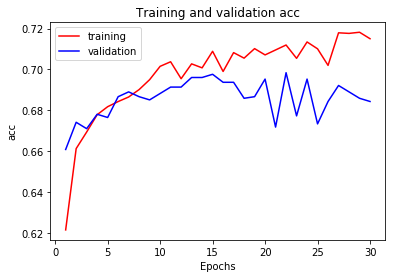

In [62]:
# Generate plots to assess the performance of the NN
ev.plot_learning_curve(history_dict = FNN_history_dict, metric = 'acc', set = 'train_valid')

In [64]:
# Test prediction for a single given cue sequence. Model expect inout as array of shape (1, N_cues) 
cue1_seq = 'y_o_u_s_s_e_f'
outcome1_prob_pred = ev.predict_proba_oneevent_FNN(model = FNN_model, 
                                                   cue_seq = cue1_seq, 
                                                   num_cues = N_cues,  
                                                   cue_index = cue_to_index)
outcome1_prob_pred

array([0.9831503 , 0.01684801], dtype=float32)

In [66]:
# Evaluate the model on the test set
prob_pred = ev.predict_proba_eventfile_FNN(model = FNN_model, 
                                           data_test = names_test, 
                                           num_cues = N_cues, 
                                           num_outcomes = N_outcomes, 
                                           cue_index = cue_to_index, 
                                           outcome_index = outcome_to_index, 
                                           generator = md.generator_df_FNN,
                                           use_multiprocessing = False, 
                                           num_threads = 0, 
                                           verbose = 0)

In [67]:
# True responses to compare the predictions to
y_test = names_test.replace({'outcomes': outcome_to_index})['outcomes']
y_pred = np.argmax(prob_pred, axis=1)+1

# Overall test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.6858407079646017

In [68]:
# Test accuracy per class
cmat = confusion_matrix(y_test, y_pred) # Confusion matrix
print(cmat.diagonal()/cmat.sum(axis=1)) 

[0.74780059 0.6231454 ]


## IV. Long short-term memory model <a ID="IV"></a> 

### Tokenisation

In [69]:
# Extract an event
event1 = names_train.iloc[[1]]
event1

,cues,outcomes
6170,k_y_r_i_e,f


In [70]:
# cues
cues1 = names_train.loc[names_train.index[1], 'cues']
cues1_onehot_LSTM = md.seq_to_onehot_2darray(cues1, index_system = cue_to_index, N_tokens = N_cues, max_len = max_len)
cues1_onehot_LSTM

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 

In [71]:
# outcomes
outcomes1 = names_train.loc[names_train.index[1], 'outcomes']
outcomes1_onehot_LSTM = md.seq_to_onehot_1darray(outcomes1, index_system = outcome_to_index, N_tokens = N_outcomes)
outcomes1_onehot_LSTM

array([0., 1.])

### Build a simple LSTM model

Build a simple LSTM that has 64 hidden units 

In [75]:
### Build a simple LSTM that has 64 hidden units 
p = {'epochs': 10, # number of iterations on the full set 
    'batch_size': 16, 
    'hidden_neuron': 64, # number of neurons in the input layer 
    'lr': 0.0001, # learning rate       
    'dropout': 0.2, 
    'optimizer': RMSprop, 
    'losses': binary_crossentropy, 
    'last_activation': 'sigmoid'}

# Model fitting
LSTM_out, LSTM_model = md.train_LSTM(data_train = names_train, 
                                     data_valid = names_valid, 
                                     num_cues = N_cues, 
                                     num_outcomes = N_outcomes, 
                                     cue_index = cue_to_index, 
                                     outcome_index = outcome_to_index, 
                                     max_len = max_len,
                                     generator = md.generator_df_LSTM,
                                     shuffle = False, 
                                     use_cuda = False,
                                     use_multiprocessing = False, 
                                     num_threads = 0, 
                                     verbose = 2,
                                     metrics = ['accuracy'],
                                     params = p)

Epoch 1/10
 - 7s - loss: 0.6889 - acc: 0.6209 - val_loss: 0.6819 - val_acc: 0.7009
Epoch 2/10
 - 5s - loss: 0.6652 - acc: 0.6598 - val_loss: 0.6431 - val_acc: 0.6540
Epoch 3/10
 - 4s - loss: 0.6330 - acc: 0.6512 - val_loss: 0.6228 - val_acc: 0.6555
Epoch 4/10
 - 4s - loss: 0.6177 - acc: 0.6633 - val_loss: 0.6094 - val_acc: 0.6615
Epoch 5/10
 - 5s - loss: 0.6044 - acc: 0.6814 - val_loss: 0.5944 - val_acc: 0.6763
Epoch 6/10
 - 3s - loss: 0.5873 - acc: 0.7023 - val_loss: 0.5771 - val_acc: 0.6979
Epoch 7/10
 - 4s - loss: 0.5703 - acc: 0.7167 - val_loss: 0.5612 - val_acc: 0.7135
Epoch 8/10
 - 5s - loss: 0.5562 - acc: 0.7256 - val_loss: 0.5509 - val_acc: 0.7262
Epoch 9/10
 - 4s - loss: 0.5469 - acc: 0.7286 - val_loss: 0.5446 - val_acc: 0.7240
Epoch 10/10
 - 3s - loss: 0.5404 - acc: 0.7332 - val_loss: 0.5398 - val_acc: 0.7314


In [76]:
LSTM_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 64)                23296     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 130       
Total params: 23,426
Trainable params: 23,426
Non-trainable params: 0
_________________________________________________________________


In [77]:
# Save the model and training history
MODEL_PATH = TOP + 'illustrative_examples/names/Results/LSTM_names.h5'
HISTORY_PATH = TOP + 'illustrative_examples/names/Results/LSTM_history_dict_names'
LSTM_model.save(MODEL_PATH)  # creates a HDF5 file 
md.save_history(history = LSTM_out, path = HISTORY_PATH)
del LSTM_model, LSTM_out  # deletes the existing model and history dictionary

# Load the model and training history
LSTM_model = load_model(MODEL_PATH)
LSTM_history_dict = md.load_history(path = HISTORY_PATH)

### Tune the parameters to find a good model

In [81]:
### Parameter tuning using grid search 
p = {'epochs': [1, 5, 10, 20, 30], # number of iterations on the full set (x5)
     'batch_size': [8, 16, 32, 64, 128, 256], # (x6)
     'hidden_neuron':[16, 32, 64, 128], # number of neurons in the input layer (x4)
     'lr': [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01], # learning rate (x7)       
     'dropout': [0, 0.1, 0.2, 0.3, 0.4], # (x5)
     'optimizer': [Adam, Nadam, RMSprop, SGD], # (x4)
     'losses': [binary_crossentropy], # (x1)
     'last_activation': ['sigmoid'] # (x1)
     }
# => Total number of combinations: 5*6*4*7*5*4*1*1 = 16800

### Grid search 
TUNING_PATH = TOP + 'illustrative_examples/names/Results/grid_search_LSTM_names.csv'
md.grid_search_LSTM(data_train = names_train, 
                    data_valid = names_valid, 
                    num_cues = N_cues, 
                    num_outcomes = N_outcomes, 
                    cue_index = cue_to_index, 
                    outcome_index = outcome_to_index,
                    max_len = max_len,
                    generator = md.generator_df_LSTM,
                    params = p,
                    prop_grid = 6e-4, 
                    tuning_output_file = TUNING_PATH, 
                    shuffle = False, 
                    use_cuda = False,
                    use_multiprocessing = False, 
                    num_threads = 0, 
                    verbose = 0)

Iteration 1 out of 10: {'epochs': 10, 'batch_size': 16, 'hidden_neuron': 128, 'lr': 0.001, 'dropout': 0.1, 'optimizer': <class 'keras.optimizers.SGD'>, 'losses': <function binary_crossentropy at 0x7fb6276b7d90>, 'last_activation': 'sigmoid'}

Iteration 2 out of 10: {'epochs': 1, 'batch_size': 128, 'hidden_neuron': 128, 'lr': 0.002, 'dropout': 0.2, 'optimizer': <class 'keras.optimizers.SGD'>, 'losses': <function binary_crossentropy at 0x7fb6276b7d90>, 'last_activation': 'sigmoid'}

Iteration 3 out of 10: {'epochs': 5, 'batch_size': 8, 'hidden_neuron': 64, 'lr': 0.002, 'dropout': 0, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function binary_crossentropy at 0x7fb6276b7d90>, 'last_activation': 'sigmoid'}

Iteration 4 out of 10: {'epochs': 10, 'batch_size': 128, 'hidden_neuron': 16, 'lr': 0.005, 'dropout': 0.3, 'optimizer': <class 'keras.optimizers.Adam'>, 'losses': <function binary_crossentropy at 0x7fb6276b7d90>, 'last_activation': 'sigmoid'}

Iteration 5 out of 10: {'epochs

### Assessing the grid search using talos

In [82]:
# Import the results file to analyse the results with talos
r = ta.Reporting(TUNING_PATH)

# get the highest result for any metric
print(f"- Highest validation accuracy: {r.high('val_acc')}")
print(f"- Highest validation f1-score: {r.high('f1score')}")

- Highest validation accuracy: 0.8162202380952381
- Highest validation f1-score: 0.8189097879383065


In [83]:
# get the round with the best result
r.rounds2high(metric = 'val_acc')

2

In [84]:
# get the best paramaters
r.data.iloc[2,]

epochs                                                            5
batch_size                                                        8
hidden_neuron                                                    64
lr                                                            0.002
dropout                                                           0
optimizer                           <class 'keras.optimizers.Adam'>
losses             <function binary_crossentropy at 0x7fb6276b7d90>
last_activation                                             sigmoid
loss                                                       0.410932
acc                                                        0.818768
precision                                                  0.818906
recall                                                     0.819137
f1score                                                     0.81891
val_loss                                                   0.439665
val_acc                                         

### Retraining with the best parameters

In [85]:
### Hyperparameters to use
p = {'epochs': 5, # number of iterations on the full set 
    'batch_size': 8, 
    'hidden_neuron': 64, # number of neurons in the input layer 
    'lr': 0.002, # learning rate       
    'dropout': 0, 
    'optimizer': Adam, 
    'losses': binary_crossentropy, 
    'last_activation': 'sigmoid'}

# Model fitting
LSTM_out, LSTM_model = md.train_LSTM(data_train = names_train, 
                                     data_valid = names_valid, 
                                     num_cues = N_cues, 
                                     num_outcomes = N_outcomes, 
                                     cue_index = cue_to_index, 
                                     outcome_index = outcome_to_index, 
                                     max_len = max_len,
                                     generator = md.generator_df_LSTM,
                                     shuffle = False, 
                                     use_cuda = False,
                                     use_multiprocessing = False, 
                                     num_threads = 0, 
                                     verbose = 2,
                                     metrics = ['accuracy'],
                                     params = p)

Epoch 1/5
 - 9s - loss: 0.5797 - acc: 0.6987 - val_loss: 0.5327 - val_acc: 0.7530
Epoch 2/5
 - 11s - loss: 0.5108 - acc: 0.7508 - val_loss: 0.5005 - val_acc: 0.7723
Epoch 3/5
 - 11s - loss: 0.4776 - acc: 0.7682 - val_loss: 0.4762 - val_acc: 0.7879
Epoch 4/5
 - 10s - loss: 0.4441 - acc: 0.8008 - val_loss: 0.4588 - val_acc: 0.8013
Epoch 5/5
 - 8s - loss: 0.4200 - acc: 0.8115 - val_loss: 0.4470 - val_acc: 0.8058


In [86]:
# Save the model and training history
MODEL_PATH = TOP + 'illustrative_examples/names/Results/LSTM_final_names.h5'
HISTORY_PATH = TOP + 'illustrative_examples/names/Results/LSTM_final_history_dict_names'
LSTM_model.save(MODEL_PATH)  # creates a HDF5 file 
md.save_history(history = LSTM_out, path = HISTORY_PATH)
del LSTM_model, LSTM_out  # deletes the existing model and history dictionary

# Load the model and training history
LSTM_model = load_model(MODEL_PATH)
LSTM_history_dict = md.load_history(path = HISTORY_PATH)

### Evaluate the final model

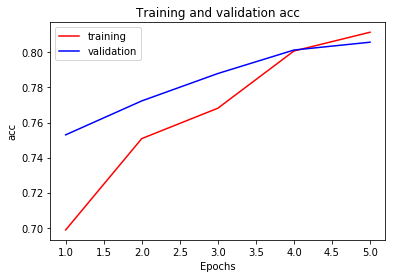

In [87]:
# Generate plots to assess the performance of the simple LSTM
ev.plot_learning_curve(history_dict = LSTM_history_dict, metric = 'acc', set = 'train_valid')

In [90]:
# Test prediction for a single given cue sequence. Model expect inout as array of shape (1, N_cues) 
cue1_seq = 'y_o_u_s_s_e_f'
outcome1_prob_pred = ev.predict_proba_oneevent_LSTM(model = LSTM_model, 
                                                   cue_seq = cue1_seq, 
                                                   num_cues = N_cues,  
                                                   cue_index = cue_to_index,
                                                   max_len = max_len)
outcome1_prob_pred

array([0.8933678, 0.1058289], dtype=float32)

In [93]:
# Evaluate the model on the test set
prob_pred = ev.predict_proba_eventfile_LSTM(model = LSTM_model, 
                                           data_test = names_test, 
                                           num_cues = N_cues, 
                                           num_outcomes = N_outcomes, 
                                           cue_index = cue_to_index, 
                                           outcome_index = outcome_to_index, 
                                           max_len = max_len,  
                                           generator = md.generator_df_LSTM,
                                           use_multiprocessing = False, 
                                           num_threads = 0, 
                                           verbose = 0)

In [94]:
# True responses to compare the predictions to
y_test = names_test.replace({'outcomes': outcome_to_index})['outcomes']
y_pred = np.argmax(prob_pred, axis=1)+1

# Overall test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.8053097345132744

In [95]:
# Test accuracy per class
cmat = confusion_matrix(y_test, y_pred) # Confusion matrix
print(cmat.diagonal()/cmat.sum(axis=1)) 

[0.81818182 0.79228487]


## V. Naive discriminative learning model <a ID="V"></a> 

### Preprocessing

In [9]:
# Convert the data sets from csv to gz formats
pr.csv_to_gz(csv_infile = NAMES_TRAIN_CSV, gz_outfile = NAMES_TRAIN_GZ)
pr.csv_to_gz(csv_infile = NAMES_VALID_CSV, gz_outfile = NAMES_VALID_GZ)
pr.csv_to_gz(csv_infile = NAMES_TEST_CSV, gz_outfile = NAMES_TEST_GZ)

### Build a simple NDL model

In [15]:
### Build a simple NDL
p = {'epochs': 10, # number of iterations on the full set 
    'lr': 0.001}

# Model fitting
NDL_history_dict, model = md.train_ndl(data_train = NAMES_TRAIN_GZ, 
                                       data_valid = NAMES_VALID_GZ, 
                                       cue_index = cue_to_index, 
                                       outcome_index = outcome_to_index, 
                                       temp_dir = TEMP_DIR,
                                       chunksize = 5426,
                                       shuffle = False, 
                                       num_threads = 8, 
                                       verbose = 1,
                                       metrics = ['accuracy'],
                                       params = p)

Epoch 1/10
 - 14s - acc: 0.6461 - val_acc: 0.6519
Epoch 2/10
 - 14s - acc: 0.6535 - val_acc: 0.6637
Epoch 3/10
 - 14s - acc: 0.6590 - val_acc: 0.6622
Epoch 4/10
 - 15s - acc: 0.6629 - val_acc: 0.6637
Epoch 5/10
 - 13s - acc: 0.6638 - val_acc: 0.6681
Epoch 6/10
 - 15s - acc: 0.6629 - val_acc: 0.6740
Epoch 7/10
 - 13s - acc: 0.6635 - val_acc: 0.6770
Epoch 8/10
 - 13s - acc: 0.6648 - val_acc: 0.6711
Epoch 9/10
 - 14s - acc: 0.6659 - val_acc: 0.6681
Epoch 10/10
 - 14s - acc: 0.6668 - val_acc: 0.6637


In [ ]:
# Save the weights and training history
MODEL_PATH = TOP + 'illustrative_examples/names/Results/NDL_names.h5'
HISTORY_PATH = TOP + 'illustrative_examples/names/Results/NDL_history_dict_names'
FNN_model.save(MODEL_PATH)  # creates a HDF5 file 
md.save_history(history = NDL_out, path = HISTORY_PATH)
# del NDL_model, NDL_out  # deletes the existing model and history dictionary

# Load the model and training history
NDL_model = load_model(MODEL_PATH)
NDL_history_dict = md.load_history(path = HISTORY_PATH)

### Tune the parameters to find a good model

In [ ]:
### Parameter tuning using grid search 
p = {'alpha': [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05], # learning rate (x8)
     'epochs': [1, 2, 4, 6, 8, 10], # number of iterations on the full set (x6)
     }
# => Total number of combinations: 8*6 = 48

### Grid search 
TUNING_PATH = TOP + 'illustrative_examples/names/Results/grid_search_NDL_names.csv'
md.grid_search_NDL(data_train = NAMES_TRAIN_GZ, 
                   data_valid = NAMES_VALID_GZ, 
                   cue_index = cue_to_index, 
                   outcome_index = outcome_to_index,
                   temp_dir = TEMP_DIR,
                   tuning_output_file = TUNING_PATH, 
                   params = p,
                   prop_grid = 0.1, 
                   shuffle = False, 
                   num_threads = 8, 
                   verbose = 1)

### Evaluate the final model

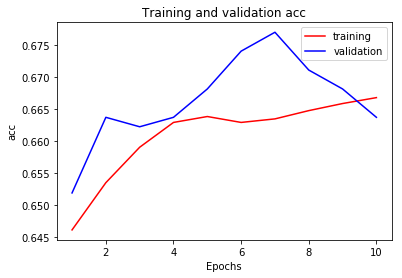

In [22]:
# Generate plots to assess the performance of the NN
ev.plot_learning_curve(history_dict = NDL_history_dict, metric = 'acc', set = 'train_valid')